In [ ]:
# 1. Thêm các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

## Chuẩn bị dữ liệu:
- Input: X_train, X_val, X_test (đúng chiều chưa ?)
* Luồng: Input -> conv layer --flatten --> vector -> dense layer -> softmax -> vector y_hat
- Output: Y_train, Y_val, Y_test (dạng one hot ?)

Load dữ liệu từ MNIST dataset, bao gồm 60.000 training set và 10.000 test set. Sau đó chia bộ traning set thành 2: 50.000 cho training set và 10.000 dữ liệu cho validation set.

In [ ]:
# 2. Load dữ liệu MNIST
# Kích thước ảnh không hề có depth vì ảnh xám là matrix, not tensor => do đó cần reshape thêm 1 chiều nữa cho đúng với yc của model trong keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_val, y_val = X_train[50000:60000,:], y_train[50000:60000]
X_train, y_train = X_train[:50000,:], y_train[:50000]
print(X_train.shape)
print(X_val.shape)

(50000, 28, 28)
(10000, 28, 28)


Dữ liệu input cho mô hình convolutional neural network là 1 tensor 4 chiều (N, H, W, D), trong bài này là ảnh xám nên W = H = 28, D = 1, N là số lượng ảnh cho mỗi lần training. Do dữ liệu ảnh ở trên có kích thước là (N, 28, 28) tức là (N, H, W) nên rần reshape lại thành kích thước N * 28 * 28 * 1 để giống kích thước mà keras yêu cầu.

In [ ]:
# 3. Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Normalize về 0-1, giúp tính toán không bị số quá lớn, tràn bộ nhớ
X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.
print(X_train.shape)

(50000, 28, 28, 1)


Bước này chuyển đổi one-hot encoding label Y của ảnh ví dụ số 5 thành vector [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [ ]:
# 4. One hot encoding label (Y)
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',Y_train[0])

Dữ liệu y ban đầu  5
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Bước này định nghĩa model:
1. Model = Sequential() để nói cho keras là ta sẽ xếp các layer lên nhau để tạo model. Ví dụ input -> CONV -> POOL -> CONV -> POOL -> FLATTEN -> FC -> OUTPUT
2.  Ở layer đầu tiên cần chỉ rõ input_shape của ảnh, input_shape = (W, H, D), ta dùng ảnh xám kích thước (28,28) nên input_shape = (28, 28, 1)
3. Khi thêm Convolutional Layer ta cần chỉ rõ các tham số: K (số lượng layer), kernel size (W, H), hàm activation sử dụng. cấu trúc: model.add(Conv2D(K, (W, H), activation='tên_hàm_activation'))
4. Khi thêm Maxpooling Layer cần chỉ rõ size của kernel, model.add(MaxPooling2D(pool_size=(W, H)))
5. Bước Flatten chuyển từ tensor sang vector chỉ cần thêm flatten layer.
6. Để thêm Fully Connected Layer (FC) cần chỉ rõ số lượng node trong layer và hàm activation sử dụng trong layer, cấu trúc: model.add(Dense(số_lượng_node activation='tên_hàm activation'))


Đọc thêm: [Weight initialize](https://www.deeplearning.ai/ai-notes/initialization/?fbclid=IwAR04qb_1PdorpX-z6_lzBb79J6-ED1VZ9BUObiwptdb7zm4eCsDXhgfDJZg), [BatchNormalization](https://towardsdatascience.com/batch-normalization-an-intuitive-explanation-42e473fa753f), [How CNN see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html?fbclid=IwAR0uDrnxp6AZkrbphhlOOzqc4KgSYn3uG75ucqnCLbZ7EK6QS9KAogjdO7Y)

In [ ]:
# BatchNormalization()
# Init Weight ()

# 5. Định nghĩa model, vẫn là sequential như neural network
model = Sequential()
 
# Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3
# dùng hàm sigmoid làm activation và chỉ rõ input_shape cho layer đầu tiên
# padding='same' (cố gắng padding sao cho input và output kích thước giống nhau)
# padding='valid' (có sao tính vậy, có mà không tính được thì sẽ bỏ đi)
# input 1 tuple 3 chiều !!
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,1)))

# Thêm Convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))

# Thêm Max pooling layer
model.add(MaxPooling2D(pool_size=(3,3)))

# Flatten layer chuyển từ tensor sang vector
# làm input của neural network
model.add(Flatten())

# Thêm Fully Connected layer với 128 nodes và dùng hàm relu
model.add(Dense(128, activation='relu'))

# Phân loại 10 lớp
# Output layer với 10 node và dùng softmax function để chuyển sang xác xuất.
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 273,130
Trainable params: 273,130
Non-trainable params: 0
________________________________________________

In [ ]:
# 6. Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức 
# đùng để tối ưu hàm loss function.
model.compile(loss='categorical_crossentropy',
              optimizer='adam', # SGD(), adam, .... gradient descent
              metrics=['accuracy'])

In [ ]:
# 7. Thực hiện train model với data
H = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          batch_size=32, epochs=10, verbose=1) #verbose: chỉ định cách trực quan quá trình model train

Epoch 1/10
1563/1563 [==============================] - 50s 4ms/step - loss: 0.3142 - accuracy: 0.9018 - val_loss: 0.0518 - val_accuracy: 0.9851
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0470 - accuracy: 0.9855 - val_loss: 0.0438 - val_accuracy: 0.9867
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0282 - accuracy: 0.9904 - val_loss: 0.0401 - val_accuracy: 0.9889
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0189 - accuracy: 0.9937 - val_loss: 0.0430 - val_accuracy: 0.9880
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0410 - val_accuracy: 0.9893
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.0484 - val_accuracy: 0.9873
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0102 - accuracy: 0.9963 - val_loss: 0.0511 - val_accuracy

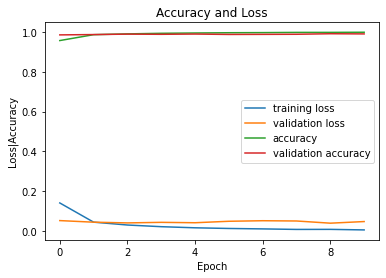

In [ ]:
# 8. Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

313/313 [==============================] - 1s 3ms/step - loss: 0.0400 - accuracy: 0.9900
[0.040044642984867096, 0.9900000095367432]


Ta sẽ dùng kết quả đánh giá của mode với test set để làm kết quả cuối cùng của model. Tức model của chúng ta dữ đoán chữ số có độ chính xác 98.92% với MNIST dataset. Nghĩa là dự đoán khoảng 100 ảnh thì sai 1 ảnh.

Giá trị dự đoán:  7


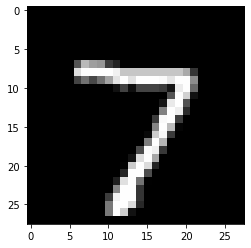

In [ ]:
# 10. Dự đoán ảnh
plt.imshow(X_test[0].reshape(28,28), cmap='gray')

y_predict = model.predict(X_test[0].reshape(1,28,28,1))
print('Giá trị dự đoán: ', np.argmax(y_predict))